# Training an SNN using surrogate gradients!

Train your first SNN in JAX in less than 10 minutes without needing a heavy-duty GPU!

In [1]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".70"
from jax import numpy as jnp
import jmp
import numpy as np

from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib notebook
import graphviz
import mediapy as media

/home/legion/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/legion/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Set Mixed Precision Policy

In [2]:
policy = jmp.get_policy('half')

hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.LIF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)

## Data Loading

In [3]:
shd_dl = spyx.data.SHD_loader(128,100,350)

In [4]:
shd_dl.train_step().obs.shape

(128, 100, 350)

## SNN

Here we define a simple feed-forward SNN using Haiku's RNN features, incorporating our
LIF neuron models where activation functions would usually go. Haiku manages all of the state for us, so when we transform the function and get an apply() function we just need to pass the params!

Since spiking neurons have a discrete all-or-nothing activation, in order to do gradient descent we'll have to approximate the derivative of the Heaviside function with something smoother. In this case, we use the SuperSpike surrogate gradient from Zenke & Ganguli 2017.
Also not that we aren't using bias terms on the linear layers and since the inputs are images, we flatten the data before feeding it to the first layer.

Depending on computational constraints, we can use haiku's dynamic unroll to iterate the SNN, or we can use static unroll where the SNN will be unrolled during the JIT compiling process to further increase speed when training on GPU. Note that the static unroll will take longer to compile, but once it runs the iterations per second will be 2x-3x greater than the dynamic unroll.

In [5]:
def shd_snn(x):
    # seqs is [T, F].
    core = hk.DeepRNN([
        hk.Linear(128, with_bias=False),
        snn.ALIF(128, activation=spyx.activation.SuperSpike()),
        hk.Linear(128, with_bias=False),
        snn.ALIF(128, activation=spyx.activation.SuperSpike()),
        hk.Linear(128, with_bias=False),
        snn.ALIF(128, activation=spyx.activation.SuperSpike()),
        hk.Linear(20, with_bias=False),
        snn.LI(20)
    ])
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x.astype(jnp.float32), core.initial_state(x.shape[0]), time_major=False, unroll=10)
    return spikes, V

In [6]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.without_apply_rng(hk.transform(shd_snn))
params = SNN.init(rng=key, x=shd_dl.train_step().obs)

## Gradient Descent

We define a training loop below.

We use the Lion optimizer from Optax, which is a more efficient competitor to the popular Adam. The eval steps and updates are JIT'ed to maximize time spent in optimized GPU code and minimize time spent in higher-level python.

The use of regularizers in the spiking network will be covered in a seperate tutorial.

In [7]:
def gd(SNN, params, dl, epochs=50, test_every=1):
    
    # create and initialize the optimizer
    opt = optax.lion(3e-4)
    opt_state = opt.init(params)
    grad_params = params
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return spyx.loss.integral_crossentropy(traces, targets)
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    # compile the meat of our training loop for speed
    @jax.jit
    def step(grad_params, opt_state, events, targets):
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, events, targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        return optax.apply_updates(grad_params, updates), opt_state, loss
    
    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, events, targets):
        readout = SNN.apply(grad_params, events)
        traces, V_f = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        loss = spyx.loss.integral_crossentropy(traces, targets)
        return acc, pred, loss
        
    # Here's the start of our training loop!
    for gen in range(epochs):
        # reset our training data loader so we're at the beginning of the train set
        # important to reset loader before making pbar so that the len of the dataset is correct.
        dl.train_reset()
        # make a progress bar with tqdm so things look official
        pbar = tqdm([*range(dl.train_len//dl.batch_size)])
        pbar.set_description("Epoch #{}".format(gen))

        for _ in pbar:
            # fetch the batch and the labels
            events, targets = dl.train_step() 
            # compute new params and loss
            grad_params, opt_state, loss = step(grad_params, opt_state, events, targets)
            #update progress bar
            pbar.set_postfix(Loss=loss)
            
        # after a number of epochs, check performance on validation set
        if gen % test_every == test_every-1:
            # reset validation iterator
            dl.val_reset()
            
            # containers for SNN results. Can return these if desired.
            accs = []
            preds = []
            losses = []
            
            # progress bars!
            pbar = tqdm([*range(dl.val_len//dl.batch_size)])
            pbar.set_description("Validating")
            for _ in pbar:
                # get validation batch
                events, targets = dl.val_step()
                # get perfomance on validation batch
                acc, pred, loss = eval_step(grad_params, events, targets)
                # save accuracy, prediction, loss
                accs.append(acc)
                preds.append(pred)
                losses.append(loss)
                # update progress bar, showing running loss and accuracy
                pbar.set_postfix(Loss=np.mean(losses), Accuracy=np.mean(accs))
                
    # return our final, optimized network.       
    return grad_params

In [8]:
def test_gd(SNN, params, dl):
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return spyx.loss.integral_crossentropy(traces, targets)
    
    @jax.jit
    def eval_step(grad_params, events, targets):
        readout = SNN.apply(grad_params, events)
        traces, V_f = readout
        acc, pred = spyx.loss.integral_accuracy(traces, targets)
        loss = spyx.loss.integral_crossentropy(traces, targets)
        return acc, pred, loss
    
    dl.test_reset()
    accs = []
    preds = []
    tgts = []
    losses = []
    pbar = tqdm([*range(dl.test_len//dl.batch_size)])
    pbar.set_description("Validating")
    for _ in pbar:
        events, targets = dl.test_step()
        
        acc, pred, loss = eval_step(grad_params, events, targets)
        
        accs.append(acc)
        preds.append(pred)
        tgts.append(targets)
        losses.append(loss)
        
        pbar.set_postfix(Loss=np.mean(losses), Accuracy=np.mean(accs))
    
    tgts = jnp.array(tgts).flatten()
    preds = jnp.array(preds).flatten()
    return accs, preds, tgts, losses

## Training Time

We'll train the network for 50 epochs since SHD is more difficult than MNIST.

The SHD dataloader for Spyx has built-in leave-one-group-out cross validation. This is becuase the test set for SHD has two unseen speakers, so when we train our model we need to make it robust to speakers it isn't training on in the hopes of improving generalization accuracy.

In [9]:
grad_params = gd(SNN, params, shd_dl)

Validating: 100%|██████| 7/7 [00:03<00:00,  2.22it/s, Accuracy=0.887, Loss=1.82]


In [10]:
grad_params = gd(SNN, grad_params, shd_dl)

Validating: 100%|██████| 7/7 [00:03<00:00,  2.17it/s, Accuracy=0.951, Loss=1.72]


## Evaluation Time

Now we'll run the network on the test set and see what happens:

In [11]:
acc, preds, tgts, losses = test_gd(SNN, grad_params, shd_dl)

Validating: 100%|████| 17/17 [00:07<00:00,  2.19it/s, Accuracy=0.763, Loss=2.02]


<IPython.core.display.Javascript object>


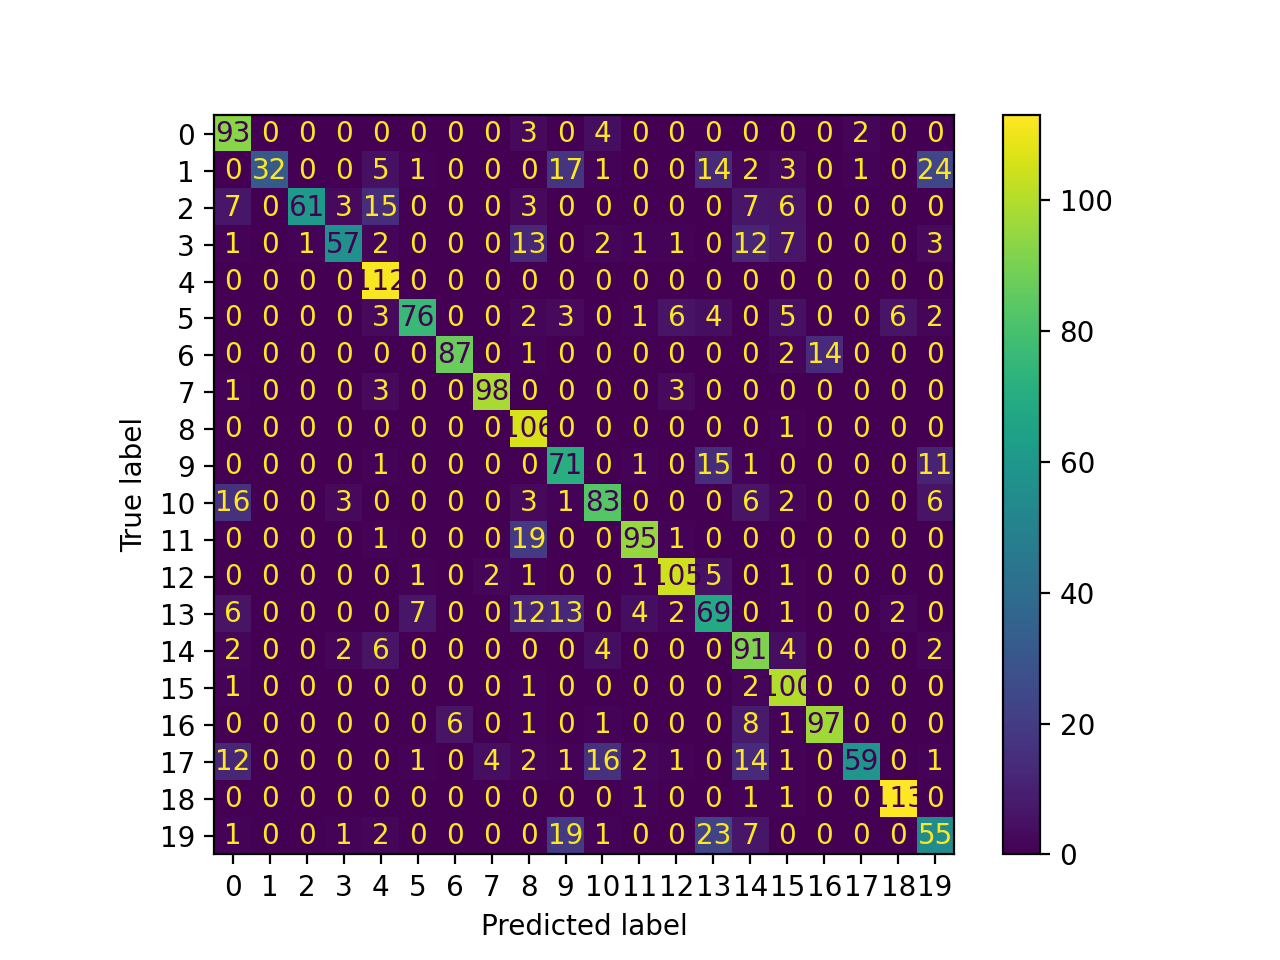

In [12]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()